In [ ]:
from statsmodels.tsa.stattools import acf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error

In [ ]:
df1 = pd.read_csv('/content/KwhConsumptionBlower78_1.csv')
df2 = pd.read_csv('/content/KwhConsumptionBlower78_2.csv')
df3 = pd.read_csv('/content/KwhConsumptionBlower78_2.csv')

In [ ]:
data = pd.concat([df1, df2, df3], ignore_index=True)

In [ ]:
data['Date'] = data['TxnDate'] + ' ' + data['TxnTime']
data.drop(columns=['TxnDate', 'TxnTime', 'Unnamed: 0'], inplace=True)

In [ ]:
data = data[['Date', 'Consumption']]

In [ ]:
data = data.sort_values(by='Date', ascending=True)

In [ ]:
#формат даты (не обязателен)
data['Date'] = pd.to_datetime(data['Date'], format="%d %b %Y %H:%M:%S")

In [ ]:
# Разделим на тренировочную и тестовую выборки
train_size = int(len(data) * 0.8)
train_data, test_data = data[0:train_size], data[train_size:]

In [ ]:
data

,Date,Consumption
43,01 Jan 2022 00:22:28,1.030
19,01 Jan 2022 00:42:33,0.904
25,01 Jan 2022 01:01:51,0.904
11,01 Jan 2022 01:41:48,1.850
29,01 Jan 2022 02:22:52,1.878
...,...,...
2424,31 Jan 2022 23:12:04,4.048
1809,31 Jan 2022 23:36:31,4.312
2439,31 Jan 2022 23:36:31,4.312
1836,31 Jan 2022 23:57:07,2.082


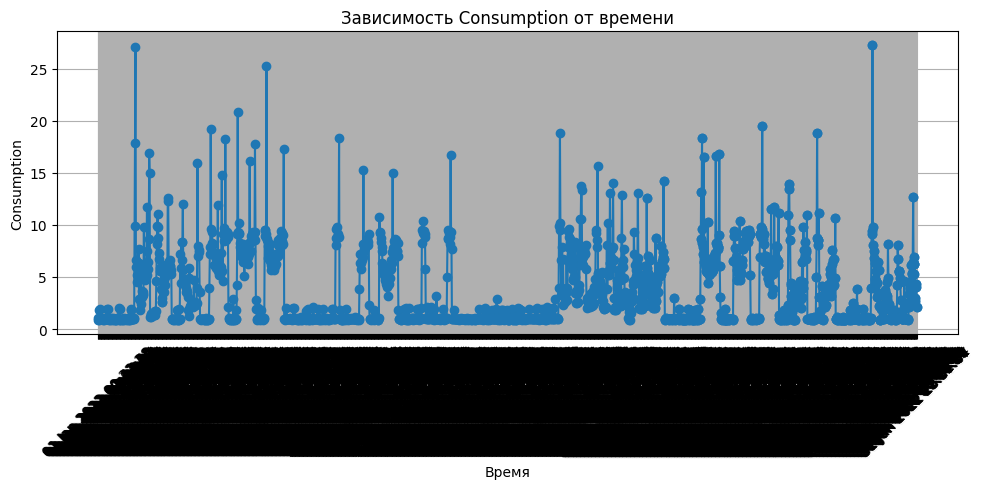

In [ ]:
# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(data['Date'], data['Consumption'], marker='o')
plt.title('Зависимость Consumption от времени')
plt.xlabel('Время')
plt.ylabel('Consumption')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

<Axes: >

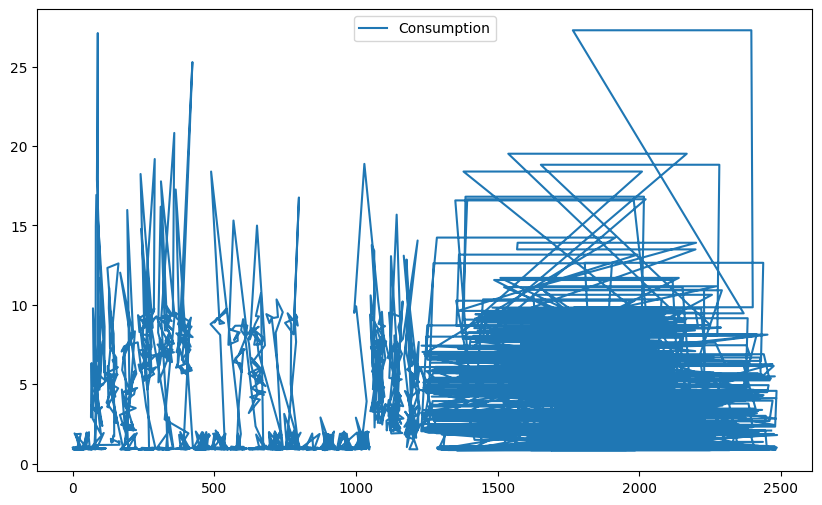

In [ ]:
data.plot(figsize=(10, 6))

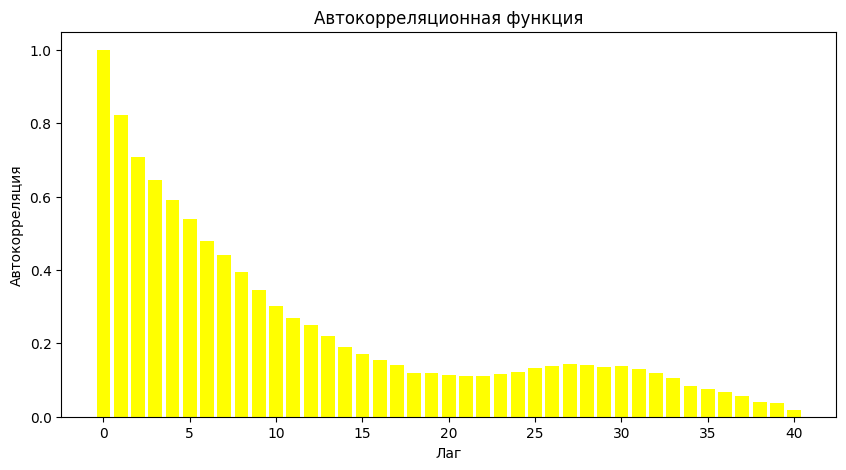

In [ ]:
lags = 40  # Количество лагов для анализа
acf_values = acf(data['Consumption'], nlags=lags)

# Визуализация
plt.figure(figsize=(10, 5))
plt.bar(range(lags + 1), acf_values, color='yellow')
plt.xlabel('Лаг')
plt.ylabel('Автокорреляция')
plt.title('Автокорреляционная функция')
plt.show()

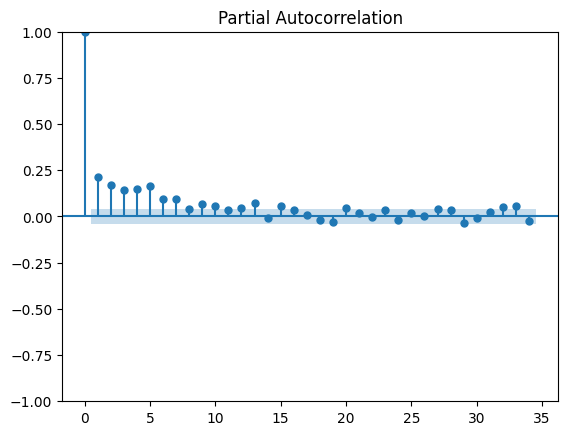

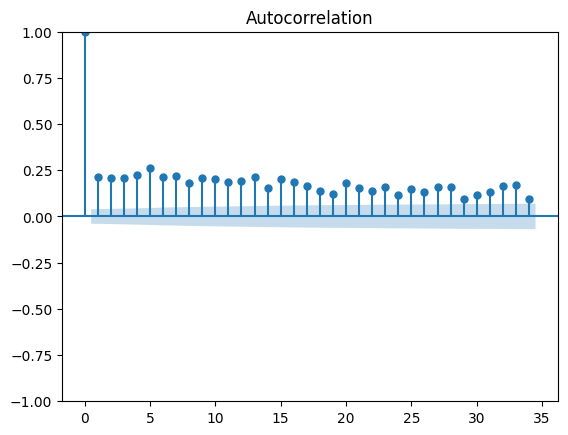

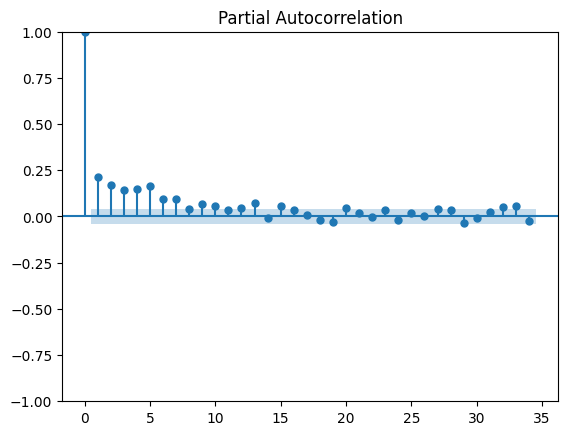

In [ ]:
plot_acf(data['Consumption'])
plot_pacf(data['Consumption'])

In [ ]:
def test_stationarity(timeseries):
    print('Результаты теста Дики-Фуллера:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    if dfoutput['p-value'] <= 0.05:
        print("Ряд стационарен (отвергаем нулевую гипотезу)")
    else:
        print("Ряд нестационарен (не отвергаем нулевую гипотезу)")

In [ ]:
print("До дифференцирования:")
test_stationarity(train_data['Consumption'])

До дифференцирования:
Результаты теста Дики-Фуллера:
Test Statistic                -9.407681e+00
p-value                        5.950432e-16
#Lags Used                     3.000000e+00
Number of Observations Used    1.986000e+03
Critical Value (1%)           -3.433647e+00
Critical Value (5%)           -2.862996e+00
Critical Value (10%)          -2.567545e+00
dtype: float64
Ряд стационарен (отвергаем нулевую гипотезу)


In [ ]:
# Если ряд нестационарен, применяем дифференцирование (d)
# Попробуем первое дифференцирование
diff_data = data.diff().dropna()
print("\nПосле первого дифференцирования:")
test_stationarity(diff_data['Consumption'])

In [ ]:
# 5. Построение и обучение модели ARIMA
arima_order = (1, 1, 1) # (p, d, q)
model = ARIMA(train_data['Consumption'], order=arima_order)
model_fit = model.fit()

print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                 1990
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4235.603
Date:                Mon, 09 Jun 2025   AIC                           8477.207
Time:                        09:04:03   BIC                           8493.993
Sample:                             0   HQIC                          8483.372
                               - 1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7570      0.011     70.074      0.000       0.736       0.778
ma.L1         -0.9674      0.007   -136.171      0.000      -0.981      -0.954
sigma2         4.1398      0.045     91.163      0.0

In [27]:
# 6. Прогнозирование
forecast_steps = len(test_data)
forecast = model_fit.predict(start=len(test_data), end=len(test_data) + forecast_steps -1)

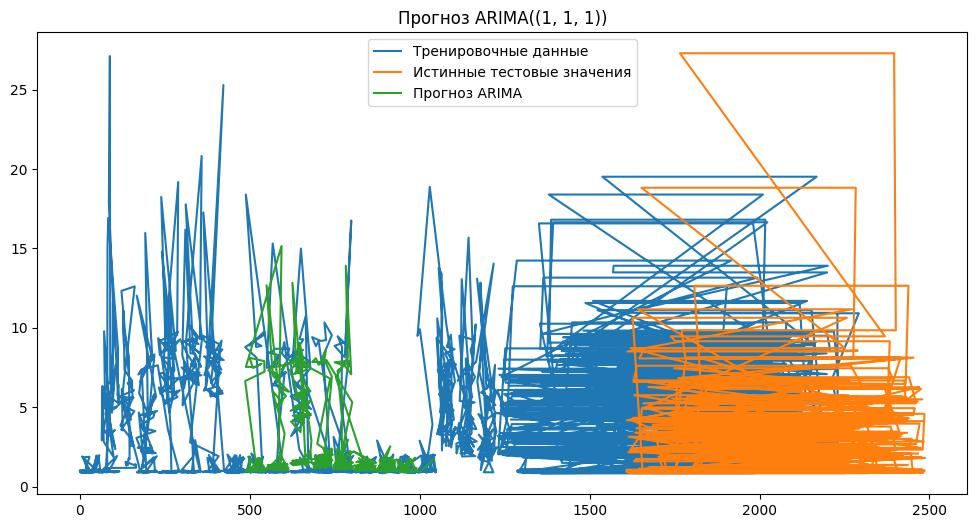

RMSE для ARIMA: 3.568


In [31]:
# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(train_data['Consumption'], label='Тренировочные данные')
plt.plot(test_data['Consumption'], label='Истинные тестовые значения')
plt.plot(forecast, label='Прогноз ARIMA')
plt.title(f'Прогноз ARIMA({arima_order})')
plt.legend()
plt.show()

# Оценка производительности (например, Mean Squared Error)
rmse = np.sqrt(mean_squared_error(test_data['Consumption'], forecast))
print(f'RMSE для ARIMA: {rmse:.3f}')

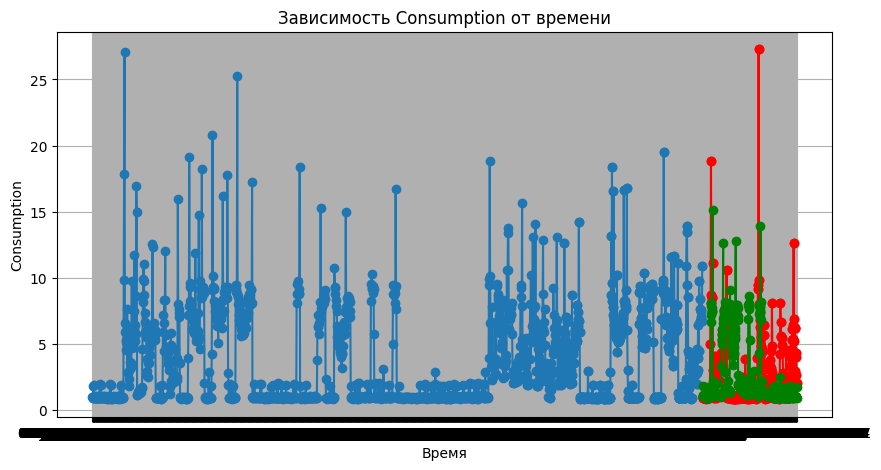

In [34]:
# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(train_data['Date'], train_data['Consumption'], marker='o')
plt.plot(test_data['Date'], test_data['Consumption'], marker='o', color='red', label='test')
plt.plot(test_data['Date'], forecast, marker='o', color='green', label='prediction')

plt.title('Зависимость Consumption от времени')
plt.xlabel('Время')
plt.ylabel('Consumption')
#plt.xticks(rotation=45)
plt.grid()
#plt.tight_layout()
plt.show()